**IMPORTANT** - running on the full Preston observatory uses about 12GB of memory as of 10/14/2019

In [1]:
import csv
import random
from enum import Enum

from nquads import NQuads
from prestongraph import *

### Get provenance log

On a large preston.acis.ufl.edu observatory it can take a while to run ```preston ls```, so we store its output at a temporary location
```shell
preston ls --remote http://preston.acis.ufl.edu > tmp/nquads
```

### Index the provenance logs

In [3]:
%%time

import sys
import io

#path = "../preston.acis.ufl.edu/tmp/nquads"
#path = "../preston.acis.ufl.edu/tmp/nquads"

fullIndex = Index()

sys.stdin = io.FileIO(path)

# Parse the provenance log into a list of n-quads
for line in sys.stdin:
    nQuads = NQuads.Parse(str(line))
    for nQuad in nQuads:
        fullIndex.Ingest(nQuad)

del sys
del io

CPU times: user 1h 9min 41s, sys: 33min 5s, total: 1h 42min 47s
Wall time: 1h 43min 2s


In [9]:
print("{:,}".format(len(fullIndex.nodes)), "nodes")

3,681,269 nodes


In [5]:
for x in fullIndex.verbs: print(x)

http://purl.org/dc/terms/description
http://www.w3.org/ns/prov#qualifiedGeneration
http://www.w3.org/ns/prov#wasGeneratedBy
http://www.w3.org/ns/prov#used
http://purl.org/dc/terms/bibliographicCitation
http://www.w3.org/ns/prov#generatedAtTime
http://purl.org/pav/previousVersion
http://purl.org/pav/hasVersion
http://www.w3.org/1999/02/22-rdf-syntax-ns#seeAlso
http://purl.org/dc/elements/1.1/format
http://www.w3.org/ns/prov#startedAtTime
http://www.w3.org/ns/prov#usedBy
http://www.w3.org/ns/prov#wasStartedBy
http://www.w3.org/ns/prov#hadMember
http://www.w3.org/ns/prov#activity
http://www.w3.org/1999/02/22-rdf-syntax-ns#type
http://www.w3.org/ns/prov#wasAssociatedWith
http://purl.org/pav/createdBy


In [3]:
def PrintNodeSubTree(node, maxDepth=1, root=True):
    if root:
        for x in node.inwardTriples:
            print(x)

    if maxDepth > 0:
        for x in node.outwardTriples:
            print(x)
            PrintNodeSubTree(x.object, maxDepth - 1, False)

In [398]:
def Peek(nativeSet):
    if len(nativeSet) == 0:
        return None
    else:
        item = nativeSet.pop()
        nativeSet.add(item)
        return item

In [440]:
def ContentIsValid(content):
    return str(content).startswith("http")

### Get crawl UUIDs and sort them by date

In [399]:
class CrawlMeta:
    def __init__(self, position, date):
        # Properties
        self.position = position
        self.date = date

In [400]:
crawlDates = []
for triple in fullIndex.verbLookup["http://www.w3.org/ns/prov#startedAtTime"].triples:
    crawlUuid = triple.subject
    crawlDate = triple.object

    descriptionTriple = Peek(crawlUuid.outwardTriples & fullIndex.verbLookup["http://purl.org/dc/terms/description"].triples)
    if descriptionTriple.object == "A crawl event that discovers biodiversity archives.":
        crawlDates.append((crawlUuid, crawlDate))
    else:
        print("Ignoring non-crawl log %s (\"%s\")" % (str(crawlUuid), str(descriptionTriple.object)))
numCrawls = len(crawlDates)

crawlDates.sort(key=lambda x: x[1])

print()
# Assign some helpful metadata to each crawl
crawlMetaLookup = dict()
for i, crawlDate in enumerate(crawlDates):
    # Contaminate crawl nodes with their chronological position in the preston history
    crawlMeta = CrawlMeta(
        position=i,
        date=crawlDate[1]
    )

    crawlMetaLookup[crawlDate[0]] = crawlMeta

    print("%s\t%s\t%d" % (crawlDate[0], crawlMeta.date, crawlMeta.position))

Ignoring non-crawl log 394b5178-e861-41aa-8a35-f207af62b461 ("An event that (re-) processes existing biodiversity datasets graphs and their provenance.")
Ignoring non-crawl log 452260c8-f5e1-49de-84b0-37b2777e7643 ("An event that (re-) processes existing biodiversity datasets graphs and their provenance.")

1d711945-d205-4663-b534-6d706b8b77b6	2018-09-04T07:29:11.130Z	0
4e540f45-d7a1-40d6-a2b8-f623f1c1d566	2018-09-04T20:47:09.581Z	1
f496b900-679d-4470-99d4-9d4901f828d0	2018-09-04T20:49:40.349Z	2
e1d0c6ea-f402-4186-affd-bc10806b822f	2018-09-05T07:28:51.929Z	3
90fa570e-579f-4e98-b060-f5886019f0b6	2018-09-05T07:36:06.462Z	4
27c0f6fa-a74f-41ac-b9c4-2f596ea940a6	2018-09-07T19:02:50.655Z	5
d8952f30-4b8f-4c10-9867-b04b2807fe89	2018-09-15T22:05:29.715Z	6
f55b0d70-3b1e-4012-9109-7497481e2af5	2018-09-15T22:06:06.646Z	7
4655fd3f-3df6-4c30-b356-a02499058339	2018-09-15T22:06:44.636Z	8
e9ae04ba-79bf-4e84-8617-e155bf1bb9cf	2018-09-22T05:07:01.664Z	9
6ee12a54-7315-4181-9b67-37861ed41153	2018-09-22T05:

### Build a history for each URL

In [481]:
class UrlLifetime:
    def __init__(self, numCrawls):
        self.statuses = [Status.UNKNOWN] * numCrawls
        self.contents = [None] * numCrawls

        self.firstCrawlPosition = None
        self.lastCrawlPosition = None

        self.numBreaks = 0
        self.numContents = 0
        self.numContentChanges = 0

In [482]:
class ContentLifetime:
    def __init__(self, numCrawls):
        self.firstCrawlPosition = None
        self.lastCrawlPosition = None

### Collect the contents seen over the course of each URL's lifetime

In [483]:
%%time

contentLifetimes = dict()
urlLifetimes = dict()
for x in fullIndex.verbLookup["http://www.w3.org/ns/prov#qualifiedGeneration"].triples:
    qualGen = x.object

    # Get content
    contentTriple = Peek(qualGen.inwardTriples & fullIndex.verbLookup["http://www.w3.org/ns/prov#qualifiedGeneration"].triples)
    content = contentTriple.subject

    # Get URL
    urlTriple = Peek(qualGen.outwardTriples & fullIndex.verbLookup["http://www.w3.org/ns/prov#used"].triples)
    url = urlTriple.object

    # Get crawl
    crawlTriple = Peek(qualGen.outwardTriples & fullIndex.verbLookup["http://www.w3.org/ns/prov#activity"].triples)
    crawl = crawlTriple.object
    crawlMeta = crawlMetaLookup[crawl]

    # Fill in URL lifetime data
    if url in urlLifetimes:
        lifetime = urlLifetimes[url]
    else:
        lifetime = UrlLifetime(numCrawls)
        urlLifetimes[url] = lifetime

    if lifetime.firstCrawlPosition == None or crawlMeta.position < lifetime.firstCrawlPosition:
        lifetime.firstCrawlPosition = crawlMeta.position

    if lifetime.lastCrawlPosition == None or crawlMeta.position > lifetime.lastCrawlPosition:
        lifetime.lastCrawlPosition = crawlMeta.position

    lifetime.contents[crawlMeta.position] = content
    
    # Fill in content lifetime data
    if not ContentIsValid(content):
        if content in contentLifetimes:
            lifetime = contentLifetimes[content]
        else:
            lifetime = ContentLifetime(numCrawls)
            contentLifetimes[content] = lifetime
        
        if lifetime.firstCrawlPosition == None or crawlMeta.position < lifetime.firstCrawlPosition:
            lifetime.firstCrawlPosition = crawlMeta.position

        if lifetime.lastCrawlPosition == None or crawlMeta.position > lifetime.lastCrawlPosition:
            lifetime.lastCrawlPosition = crawlMeta.position

CPU times: user 41.3 s, sys: 12.2 ms, total: 41.3 s
Wall time: 41.6 s


In [484]:
numUrls = len(urlLifetimes)
print("{:,}".format(numUrls), "urls")

75,337 urls


### Assign a status for each stage of each URL's lifetime

In [485]:
class Status(Enum):
    UNKNOWN             = 0    # Did not check for content
    FIRST_CONTENT       = 1    # Returned content for the first time
    SAME_CONTENT        = 2    # Returned the same content as the last successful query
    CHANGED_CONTENT     = 3    # Returned new content
    OLD_CONTENT         = 4    # Returned previously seen content that is different from the previous successful data
    BECAME_UNRESOLVED   = 5    # Failed to return content after a successful query
    STILL_UNRESOLVED    = 6    # Failed to return content again
    ERROR               = 7    # Returned malformed content

There's some ambiguity in the status of a URL's first query; we make some arbitrary, totally unfounded assumptions:
* If unresolved, consider it BECAME_UNRESOLVED rather than STILL_UNRESOLVED
* If resolved, consider it FIRST_CONTENT rather than SAME_CONTENT, OLD_CONTENT, or CHANGED_CONTENT

In [486]:
%%time

for url, lifetime in urlLifetimes.items():
    wasAlive = True
    mostRecentContent = None
    for i, content in enumerate(lifetime.contents):

        if content:
            if ContentIsValid(content):
        # Became unresolved
                if wasAlive:
                    status = Status.BECAME_UNRESOLVED
                    lifetime.numBreaks += 1

        # Still unresolved
                else:
                    status = Status.STILL_UNRESOLVED

                wasAlive = False

        # First content
            else:
                if mostRecentContent == None:
                    status = Status.FIRST_CONTENT
                    mostRecentContent = content
                    lifetime.numContents += 1

        # Same content
                elif content == mostRecentContent:
                    status = Status.SAME_CONTENT

                else:
        # Old content
                    if content in lifetime.contents[0:i]:
                        status = Status.OLD_CONTENT

        # Changed content
                    else:
                        status = Status.CHANGED_CONTENT
                        lifetime.numContents += 1

                    mostRecentContent = content
                    lifetime.numContentChanges += 1

                wasAlive = True

        # Unknown
        else:
            status = Status.UNKNOWN

        lifetime.statuses[i] = status

CPU times: user 14.9 s, sys: 7.41 ms, total: 15 s
Wall time: 15 s


In [487]:
print("Lifetime for %s\n" % url)
print("\n".join(["%d:\t%s\t%s" % (i, lifetime.statuses[i], lifetime.contents[i]) for i in range(numCrawls)]))

Lifetime for http://tb.plazi.org/GgServer/dwca/FFE0FFDFC14600674E4EFF9DFFF6FF8D.zip

0:	Status.FIRST_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
1:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
2:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
3:	Status.UNKNOWN	None
4:	Status.UNKNOWN	None
5:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
6:	Status.UNKNOWN	None
7:	Status.UNKNOWN	None
8:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
9:	Status.UNKNOWN	None
10:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
11:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
12:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84f

## Build figures
These should probably be colorless (i.e. use black and white textures and dotted lines)

### New, modified, lost content per crawl

In [458]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from itertools import cycle, islice

%matplotlib inline

In [416]:
%%time

crawl_status_totals_df = pd.DataFrame(
    index   = [datetime.datetime.strptime(str(x[1]), "%Y-%m-%dT%H:%M:%S.%fZ") for x in crawlDates],
    columns = [x for x in Status],
    data    = 0,
    dtype   = int
)

for _, lifetime in urlLifetimes.items():
    for i, status in enumerate(lifetime.statuses):
        crawl_status_totals_df.iloc[i][status.value] += 1

CPU times: user 8min 57s, sys: 179 ms, total: 8min 57s
Wall time: 8min 59s


In [417]:
crawl_status_totals_df.transpose()

,2018-09-04 07:29:11.130000,2018-09-04 20:47:09.581000,2018-09-04 20:49:40.349000,2018-09-05 07:28:51.929000,2018-09-05 07:36:06.462000,2018-09-07 19:02:50.655000,2018-09-15 22:05:29.715000,2018-09-15 22:06:06.646000,2018-09-15 22:06:44.636000,2018-09-22 05:07:01.664000,...,2019-01-21 02:32:47.817000,2019-01-28 12:30:52.598000,2019-02-04 16:33:24.359000,2019-03-01 20:37:34.877000,2019-03-31 23:33:18.478000,2019-05-01 03:57:18.530000,2019-06-01 10:43:38.196000,2019-07-01 21:41:36.023000,2019-08-01 02:27:40.507000,2019-09-01 09:34:33.505000
Status.UNKNOWN,26841,26841,60146,75166,75143,35121,75319,75332,25837,75325,...,25121,34320,22955,58121,21015,20177,19649,19097,28446,19681
Status.FIRST_CONTENT,46426,48,2,68,21,932,0,0,228,0,...,6,6,4056,363,2010,15372,750,697,709,580
Status.SAME_CONTENT,0,45605,13424,28,146,33613,11,5,37040,7,...,19715,35730,36998,9812,19974,27071,39879,42826,40106,42102
Status.CHANGED_CONTENT,0,672,676,52,4,3705,4,0,10182,3,...,28685,3819,10062,2723,11516,11231,11346,11260,4814,11576
Status.OLD_CONTENT,0,0,0,0,0,0,0,0,7,0,...,0,0,158,3432,4985,0,1,27,0,2
Status.BECAME_UNRESOLVED,2070,149,70,10,0,42,0,0,104,0,...,37,173,429,315,14717,373,2286,56,254,41
Status.STILL_UNRESOLVED,0,2022,1019,13,23,1924,3,0,1939,2,...,1773,1289,679,571,1120,1113,1426,1374,1008,1355
Status.ERROR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [418]:
col_hex = {
    "blue"      : "#1f77b4",
    "orange"    : "#ff7f0e",
    "green"     : "#2ca02c",
    "red"       : "#d62728",
    "purple"    : "#9467bd",
    "brown"     : "#8c564b",
    "pink"      : "#e377c2",
    "gray"      : "#7f7f7f",
    "yellow"    : "#bcbd22",
    "teal"      : "#17becf",
    
    "bright green"  : "#00ff00",
    "bright red"    : "#ff0000",
    "green yellow"  : "#9ACD32",
    "olive"         : "#808000"
}

fig_df = crawl_status_totals_df[[
    Status.SAME_CONTENT,
    Status.FIRST_CONTENT,
    Status.OLD_CONTENT,
    Status.CHANGED_CONTENT,
    Status.STILL_UNRESOLVED,
    Status.BECAME_UNRESOLVED,
    Status.UNKNOWN,
    Status.ERROR
]]

status_colors = {
    Status.UNKNOWN             : "gray",
    Status.FIRST_CONTENT       : "bright green",
    Status.SAME_CONTENT        : "green",
    Status.CHANGED_CONTENT     : "yellow",
    Status.OLD_CONTENT         : "olive",
    Status.BECAME_UNRESOLVED   : "bright red",
    Status.STILL_UNRESOLVED    : "red",
    Status.ERROR               : "purple",
}

status_color_map = list(islice(cycle([col_hex[status_colors[x]] for x in fig_df.columns]), None, 256))

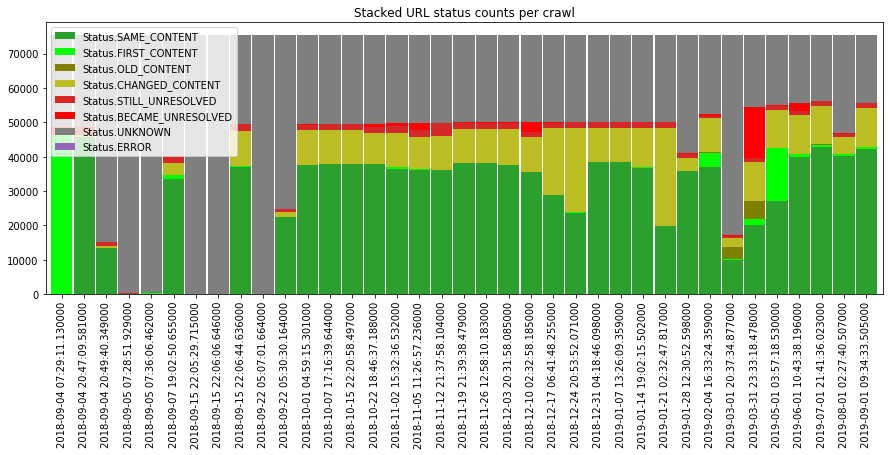

In [419]:
fig_df.plot(kind="bar", stacked=True, width=.95, color=status_color_map, figsize=(15, 5),
                      title="Stacked URL status counts per crawl");

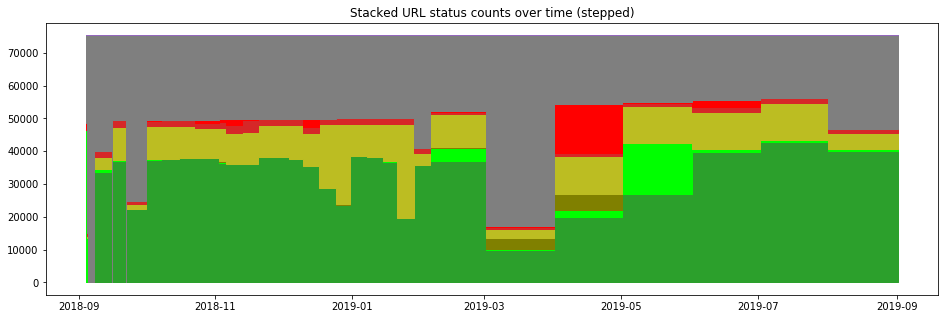

In [420]:
# Make figure
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111, title="Stacked URL status counts over time (stepped)")

# Fill in space between lines
x = fig_df.index.append(pd.Index([datetime.datetime.now()]))
y1 = pd.Series({ q : 0 for q in x })

columns = fig_df.columns
n = len(columns)
for i in range(0, n):
    y2 = y1 + fig_df[columns[i]] + 0
    ax.fill_between(x, y1, y2, step="post", color=status_color_map[i])
    y1 = y2

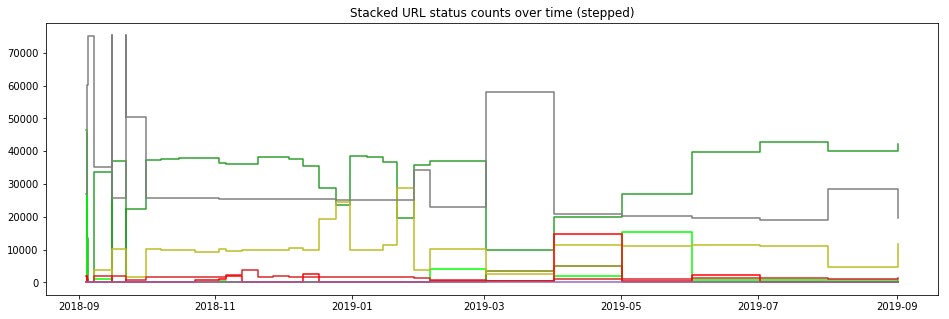

In [424]:
# Make figure
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111, title="Stacked URL status counts over time (stepped)")

# Draw stepped lines
x = fig_df.index
for status in fig_df.columns:
    y = fig_df[status]
    plt.step(x, y, where="post", color=col_hex[status_colors[status]])

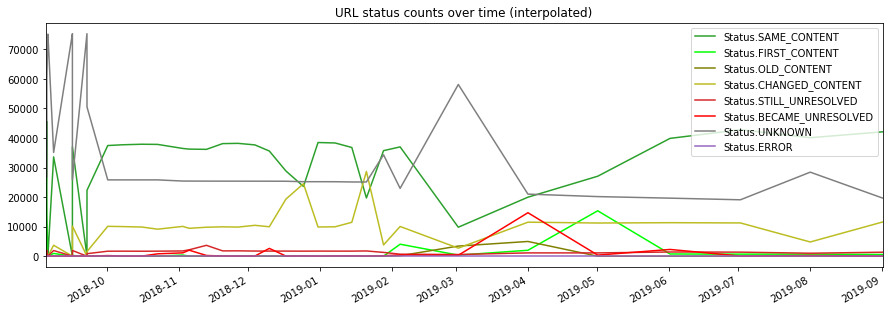

In [425]:
ax = fig_df.plot(kind="line", stacked=False, color=status_color_map, figsize=(15, 5),
                 title="URL status counts over time (interpolated)")

Fun fact: there are many URLs that never resolved

In [469]:
reallyBads = list()
for url, lifetime in urlLifetimes.items():
    skip = False
    for status in lifetime.statuses:
        if status not in (Status.BECAME_UNRESOLVED, Status.STILL_UNRESOLVED, Status.UNKNOWN):
            skip = True
            break
    if not skip:
        reallyBads.append((url, lifetime))
print("%d URLs never resolved in any crawl" % len(reallyBads))

2186 URLs never resolved in any crawl


## Running URL and dataset totals

In [470]:
#crawl_status_totals_df[[Status.FIRST_CONTENT, Status.BECAME_UNRESOLVED]].cumsum()

In [507]:
crawlUrlTotals = [0] * numCrawls
crawlDatasetTotals = [0] * numCrawls

numVeryAvailable = 0
numVeryStable = 0

totalNumBreaks = 0
totalNumContents = 0
totalNumContentChanges = 0

maxNumBreaks            = numUrls * (np.ceil(numCrawls / 2)) # Round up; if the availability is [0, 1, 0] across three crawls, there are at most two breaks
maxNumContents          = numUrls * (numCrawls)
maxNumContentChanges    = numUrls * (numCrawls - 1)

breakCounts = []
contentChangeCounts = []

for _, lifetime in urlLifetimes.items():
    #if lifetime.firstCrawlPosition:
    crawlUrlTotals[lifetime.firstCrawlPosition] += 1

    totalNumBreaks += lifetime.numBreaks
    totalNumContents += lifetime.numContents
    totalNumContentChanges += lifetime.numContentChanges

    breakCounts.append(lifetime.numBreaks)
    contentChangeCounts.append(lifetime.numContentChanges)

    if lifetime.numBreaks == 0:
        numVeryAvailable += 1

    if lifetime.numContents == 1:
        numVeryStable += 1

for _, lifetime in contentLifetimes.items():
    #if lifetime.firstCrawlPosition:
    crawlDatasetTotals[lifetime.firstCrawlPosition] += 1

In [506]:
print("%s of URLs (%s total) were always available"
      % ("{0:.2%}".format(numVeryAvailable / numUrls), "{0:,}".format(numVeryAvailable)))
print("%s of URLs (%s total) always produced the same content"
      % ("{0:.2%}".format(numVeryStable / numUrls), "{0:,}".format(numVeryStable)))
print("On average, URLs break %s of the time between queries"
      % ("{0:.2%}".format(totalNumBreaks / maxNumBreaks)))
print("On average, URLs contents change %s of the time between queries"
      % ("{0:.2%}".format(totalNumContentChanges / maxNumContentChanges)))

66.54% of URLs (50,132 total) were always available
44.19% of URLs (33,291 total) always produced the same content
URLs break 2.02% of the time between queries
URLs contents change 11.67% of the time between queries


In [523]:
breakCountFrequencies = np.unique(breakCounts, return_counts=True)

print("Number of URLs that broke n times")
for i in range(len(breakCountFrequencies[0])):
    print(breakCountFrequencies[0][i], ":", breakCountFrequencies[1][i])

Number of URLs that broke n times
0 : 50132
1 : 22099
2 : 2836
3 : 112
4 : 83
5 : 52
6 : 9
7 : 3
8 : 9
9 : 2


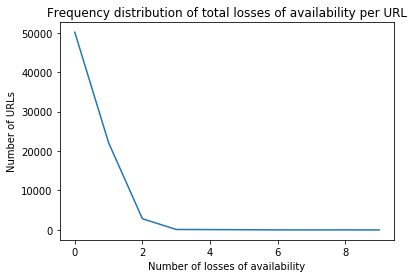

In [535]:
plt.plot(breakCountFrequencies[0], breakCountFrequencies[1]);
plt.title("Frequency distribution of total losses of availability per URL");
plt.xlabel("Number of losses of availability");
plt.ylabel("Number of URLs");

In [524]:
contentChangeCountFrequencies = np.unique(contentChangeCounts, return_counts=True)

print("Number of URLs that changed content n times")
for i in range(len(contentChangeCountFrequencies[0])):
    print(contentChangeCountFrequencies[0][i], ":", contentChangeCountFrequencies[1][i])

Number of URLs that changed content n times
0 : 35477
1 : 5133
2 : 15842
3 : 7688
4 : 334
5 : 210
6 : 82
7 : 39
8 : 37
9 : 38
10 : 29
11 : 121
12 : 428
13 : 36
14 : 9
15 : 91
16 : 26
17 : 88
18 : 44
19 : 36
20 : 42
21 : 19
22 : 4
23 : 33
24 : 5983
25 : 252
26 : 977
27 : 1228
28 : 345
29 : 30
30 : 158
31 : 428
32 : 47
33 : 3


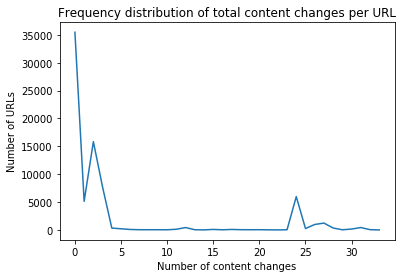

In [534]:
plt.plot(contentChangeCountFrequencies[0], contentChangeCountFrequencies[1]);
plt.title("Frequency distribution of total content changes per URL");
plt.xlabel("Number of content changes");
plt.ylabel("Number of URLs");

In [491]:
crawl_totals_df = pd.DataFrame(
    index   = [datetime.datetime.strptime(str(x[1]), "%Y-%m-%dT%H:%M:%S.%fZ") for x in crawlDates],
    columns = ["New URLs", "New Contents", "Total URLs", "Total Contents"],
    data    = 0,
    dtype   = int
)

crawl_totals_df["New URLs"] = crawlUrlTotals
crawl_totals_df["New Contents"] = crawlDatasetTotals
crawl_totals_df["Total URLs"] = crawl_totals_df["New URLs"].cumsum()
crawl_totals_df["Total Contents"] = crawl_totals_df["New Contents"].cumsum()
crawl_totals_df

,New URLs,New Contents,Total URLs,Total Contents
2018-09-04 07:29:11.130,48496,46354,48496,46354
2018-09-04 20:47:09.581,0,719,48496,47073
2018-09-04 20:49:40.349,0,685,48496,47758
2018-09-05 07:28:51.929,78,122,48574,47880
2018-09-05 07:36:06.462,21,21,48595,47901
2018-09-07 19:02:50.655,905,4641,49500,52542
2018-09-15 22:05:29.715,0,4,49500,52546
2018-09-15 22:06:06.646,0,0,49500,52546
2018-09-15 22:06:44.636,0,10399,49500,62945
2018-09-22 05:07:01.664,0,3,49500,62948


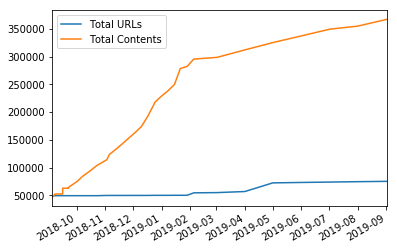

In [492]:
crawl_totals_df[["Total URLs", "Total Contents"]].plot();

In [ ]:
for lifetime in lifetimes:
    total